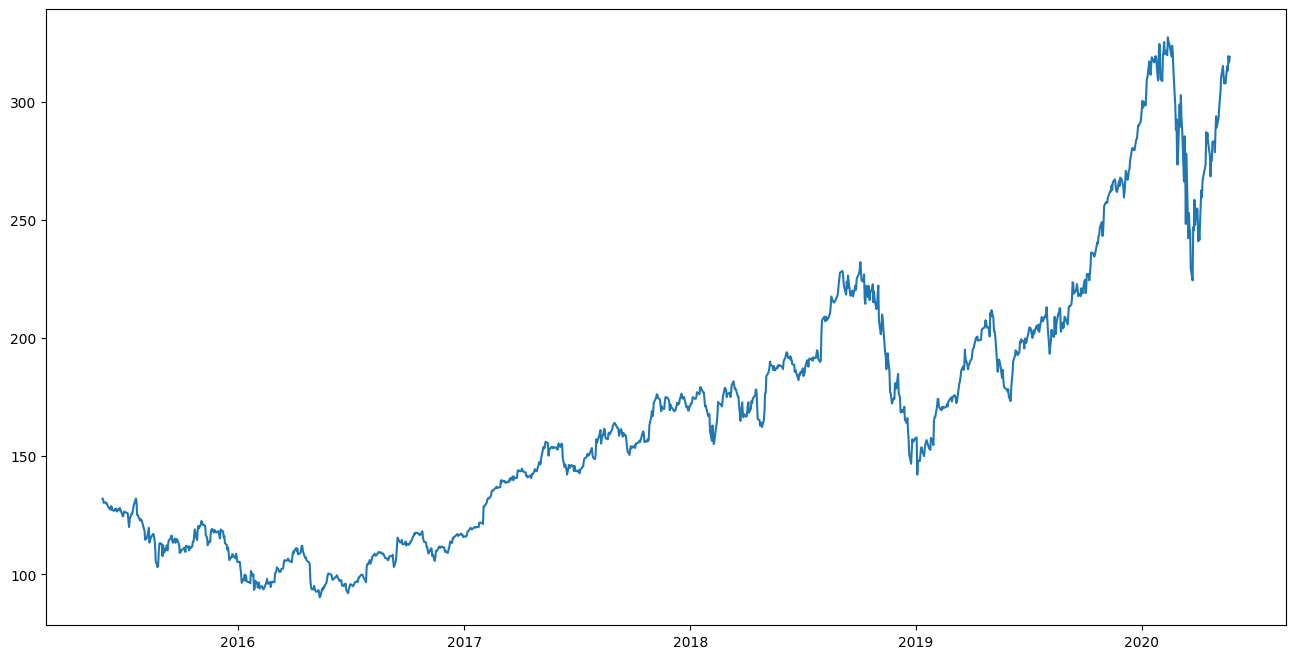



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                

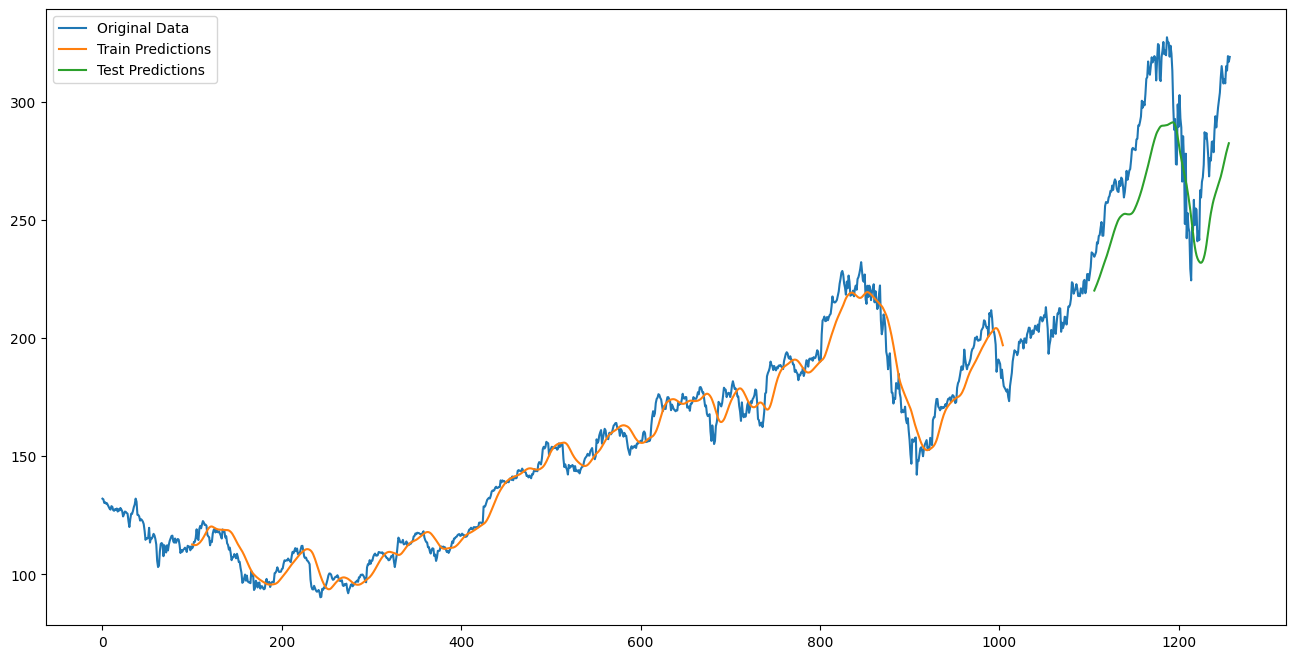

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler

# Load the data
data = pd.read_csv('AAPL.csv')

# Select relevant columns
data = data[['date', 'close']]

# Convert 'date' to datetime
data['date'] = pd.to_datetime(data['date'])

# Sort by date
data = data.sort_values('date')

# Set 'date' as the index
data.set_index('date', inplace=True)

# Plot the closing prices
plt.figure(figsize=(16,8))
plt.plot(data['close'], label='Close Price history')
plt.show()

# Data preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['close'].values.reshape(-1,1))

# Prepare training and testing datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create a dataset matrix
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the Stacked LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Print model summary
model.summary()

# Learning rate scheduler
def scheduler(epoch, lr):
    return lr * np.exp(-0.1)

callback = LearningRateScheduler(scheduler)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback])

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Plotting
look_back = time_step
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(scaled_data) - 1, :] = test_predict

plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.legend()
plt.show()


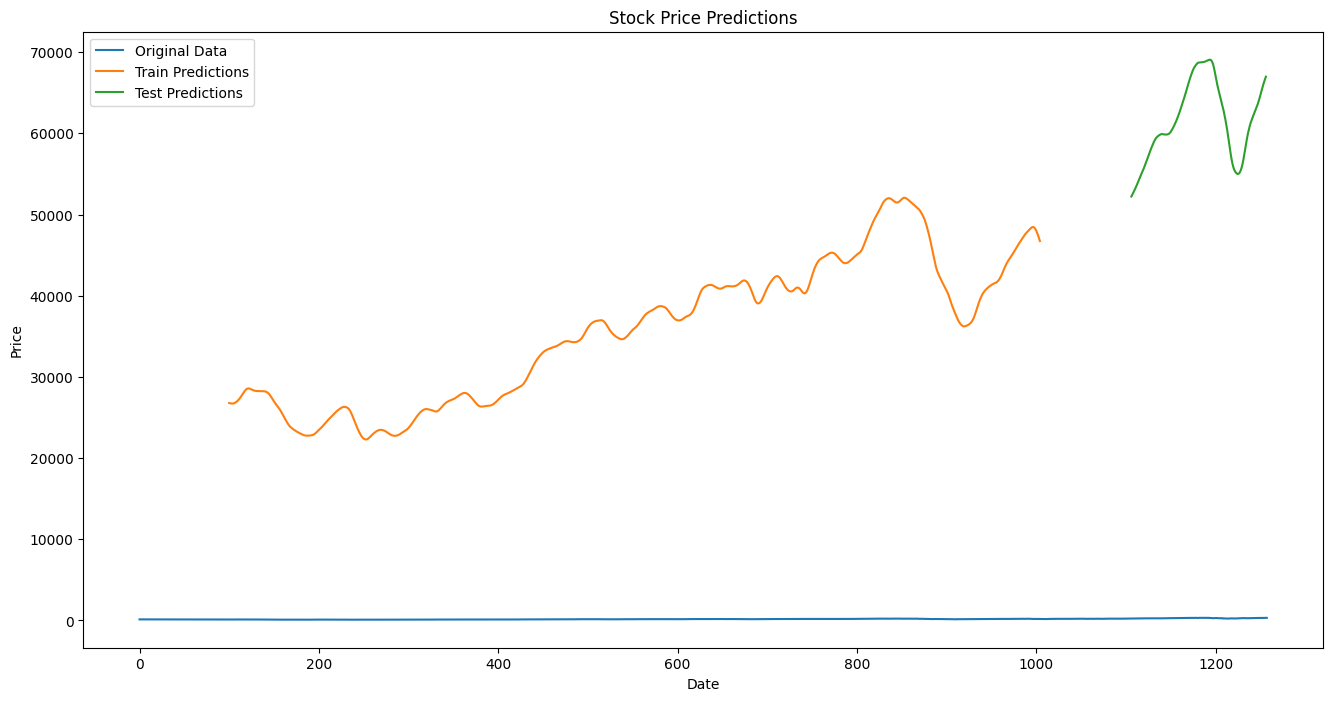

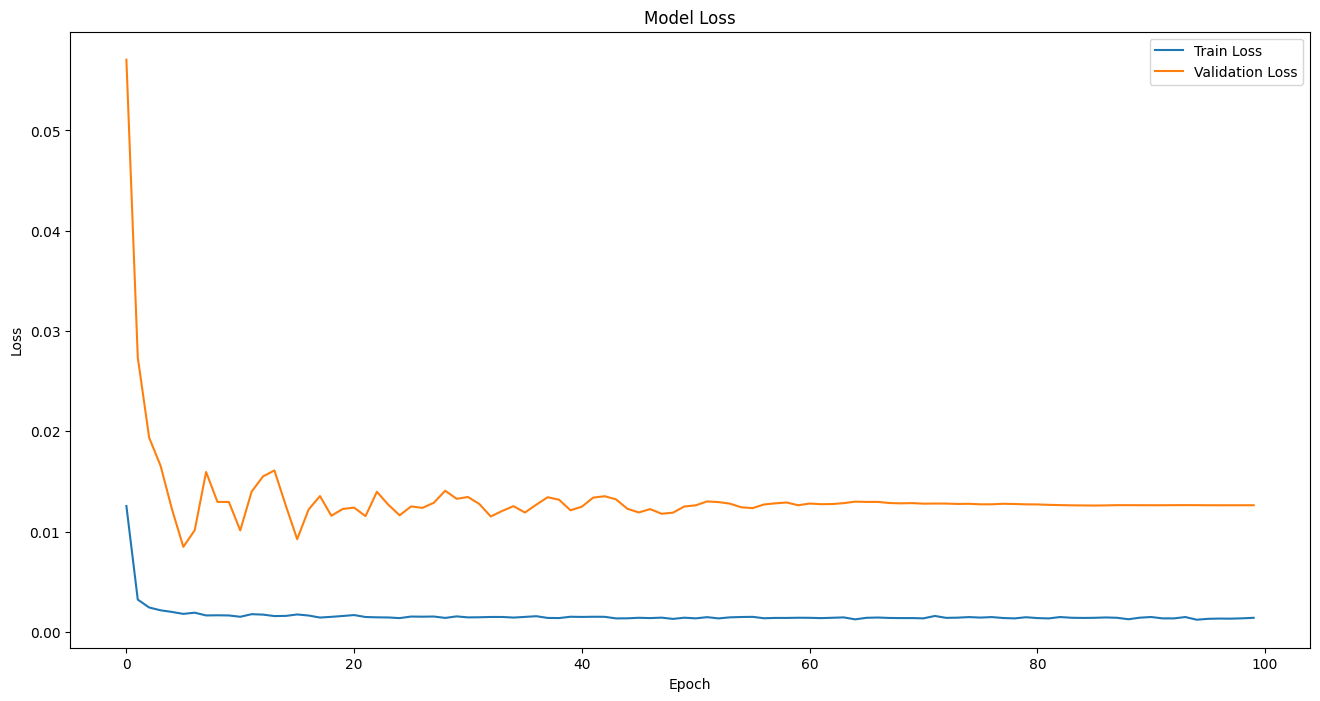

Train Score: 36308.53892344776 RMSE
Test Score: 61462.19591635093 RMSE


In [4]:


# Plotting predictions
look_back = time_step
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(scaled_data) - 1, :] = test_predict

plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plotting accuracy graphs and loss curves
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
from sklearn.metrics import mean_squared_error
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print(f'Train Score: {train_score} RMSE')
print(f'Test Score: {test_score} RMSE')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

C:\Users\aarna\AppData\Local\Temp\ipykernel_52428\173481443.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


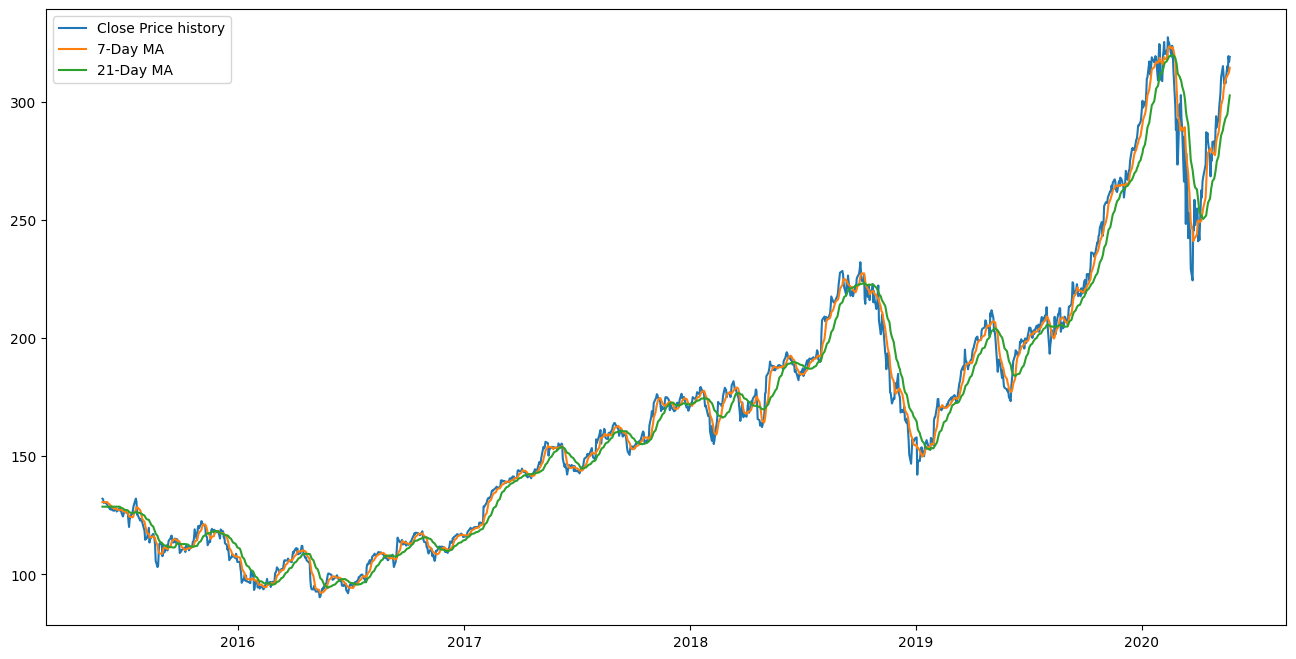

In [2]:
# Load the data
data = pd.read_csv('AAPL.csv')

# Select relevant columns
data = data[['date', 'close', 'volume']]

# Convert 'date' to datetime
data['date'] = pd.to_datetime(data['date'])

# Sort by date
data = data.sort_values('date')

# Set 'date' as the index
data.set_index('date', inplace=True)

# Feature Engineering: Add moving averages
data['ma7'] = data['close'].rolling(window=7).mean()
data['ma21'] = data['close'].rolling(window=21).mean()

# Fill NaN values
data.fillna(method='bfill', inplace=True)

# Plot the closing prices
plt.figure(figsize=(16,8))
plt.plot(data['close'], label='Close Price history')
plt.plot(data['ma7'], label='7-Day MA')
plt.plot(data['ma21'], label='21-Day MA')
plt.legend()
plt.show()

In [3]:
# Data preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

# Prepare training and testing datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create a dataset matrix
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        X.append(a)
        Y.append(dataset[i + time_step, 0])  # Predicting 'close' price
    return np.array(X), np.array(Y)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [4]:
# Build the Stacked LSTM model with Bidirectional LSTM
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(time_step, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Print model summary
model.summary()

# Learning rate scheduler
def scheduler(epoch, lr):
    return lr * np.exp(-0.1)

callback_lr = LearningRateScheduler(scheduler)

# Early stopping
callback_es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback_lr, callback_es])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 100, 100)          22000     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 100, 100)          60400     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 100, 100)          0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 100)               60400     
 onal)                                                           
                                                      

In [5]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original scale
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]
y_train = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

5/5 [==============================] - 0s 83ms/step


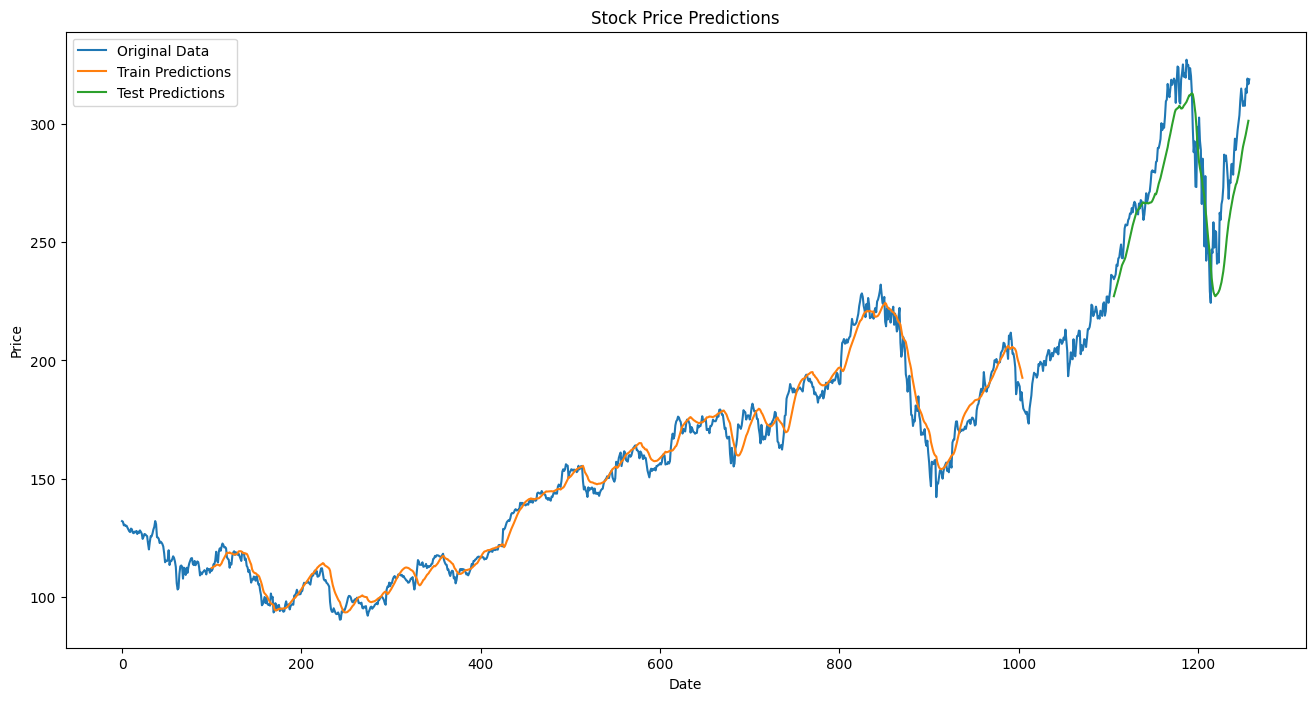

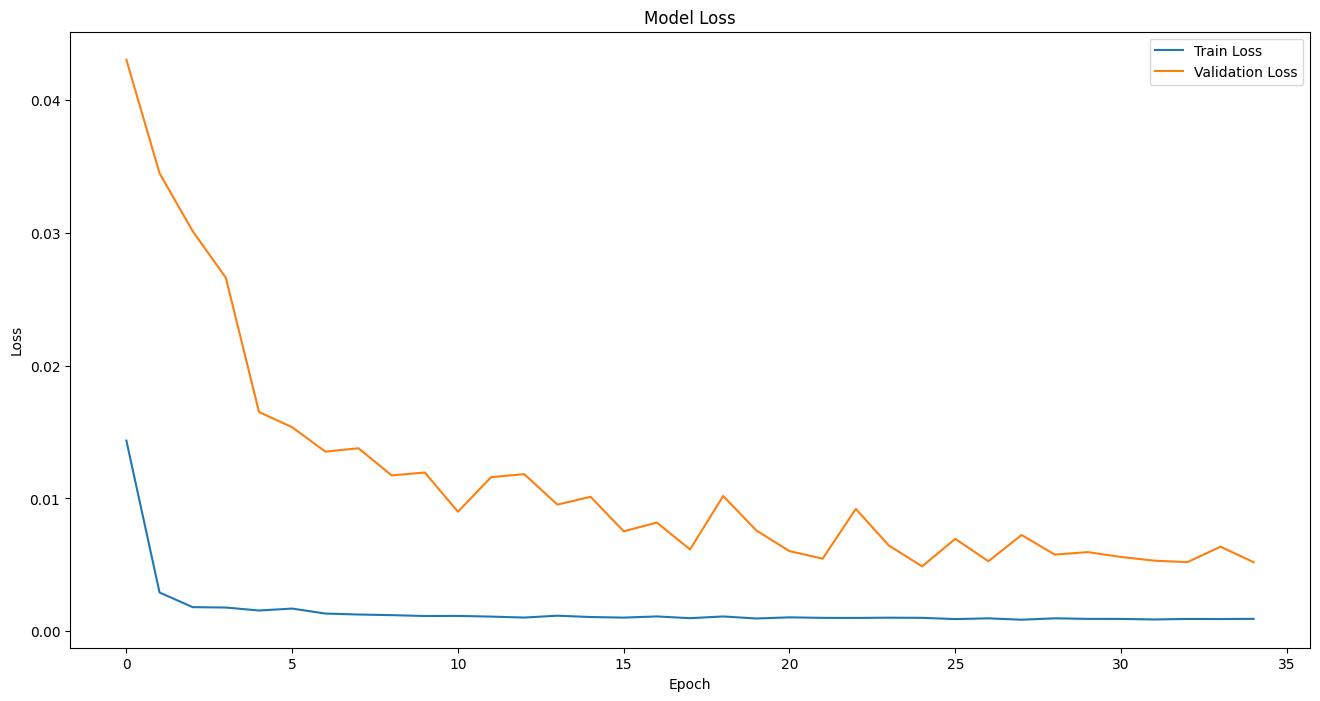

In [6]:
# Plotting
look_back = time_step
trainPredictPlot = np.empty_like(scaled_data[:, 0])
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back] = train_predict

testPredictPlot = np.empty_like(scaled_data[:, 0])
testPredictPlot[:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(scaled_data) - 1] = test_predict

plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(scaled_data)[:, 0], label='Original Data')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plotting accuracy graphs and loss curves
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
# Evaluate the model
train_score = np.sqrt(mean_squared_error(y_train, train_predict))
test_score = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Train Score: {train_score} RMSE')
print(f'Test Score: {test_score} RMSE')

Train Score: 5.26250156666299 RMSE
Test Score: 16.561658317631753 RMSE
